# Explainable AI: How to demystify machine learning models




This jupyter notebook has been created for __Applied Machine Learning Days__.

In this workshop we will take a look at __LIME__ and __SHAP__ to explain potential black-box machine learning models in a model-agnostic way. We use a real-world dataset on Census income, also known as the __[*Adult dataset*](https://archive.ics.uci.edu/ml/datasets/Adult)__ available in the *UCI* ML Repository where we will predict if the potential income of people is more than $50K/yr or not.

__[LIME GitHub](https://github.com/marcotcr/lime)__

__[SHAP GitHub](https://github.com/slundberg/shap)__

- Author: Tiba_Razmi


## Load dependencies

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import itertools

##

from sklearn.model_selection import train_test_split
from collections import Counter
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')
#plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

## Load the census data

In [143]:
X, y = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in y])
X.shape, labels.shape

((32561, 12), (32561,))

If salary is more than \$50K : True (1) or less than \$50K : False (0)

In [144]:
y

array([False, False, False, ..., False, False,  True])

# Understanding the Census Income Dataset

Let's now take a look at our dataset attributes and understand their meaning and significance.


| Attribute Name | Type | Description |
|-----------------------|----------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Age | Continuous | Represents age of the person |
| Workclass | Categorical | Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) |
| Education-Num | Categorical | Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) |
| Marital Status | Categorical | Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) |
| Occupation | Categorical | Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) |
| Relationship | Categorical | Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) |
| Race | Categorical | Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) |
| Sex | Categorical | Represents the gender of the person<br>(Female, Male) |
| Capital Gain | Continuous | The total capital gain for the person |
| Capital Loss | Continuous | The total capital loss for the person |
| Hours per week | Continuous | Total hours spent working per week |
| Country | Categorical | The country where the person is residing |
| Income Label (labels) | Categorical  (class label) | The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) |                                                                                                                                                                |

We have a total of 12 features and our objective is to predict if the income of a person will be more than \$50K (True) or less than \$50K (False). Hence we will be building and interpreting a classification model

In [145]:
X.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [146]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


## Pre-processing
Converting the categorical columns with string values to numeric representations. Typically the XGBoost model can handle categorical data natively being a tree-based model so we don't one-hot encode the features

In [147]:
cat_cols = X.select_dtypes(['category']).columns
X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.codes)
X.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

Viewing distribution of people with <=  \$50K (0) and > \$50K (1) income

In [148]:
Counter(labels)

Counter({0: 24720, 1: 7841})

In [149]:
headers=list(X.columns)
print(headers)

['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']


## Split Train and Test Datasets

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((22792, 12), (9769, 12))

In [150]:
X_train.head()

Age  Workclass  Education-Num  Marital Status  Occupation  \
19749  34.0          6            9.0               2           5   
1216   48.0          6           10.0               2           3   
27962  23.0          7           10.0               2          10   
23077  56.0          2            9.0               0           4   
10180  17.0          4            7.0               4           9   

       Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
19749             5     4    0           0.0        2179.0            12.0   
1216              0     0    1        7688.0           0.0            40.0   
27962             0     4    1           0.0           0.0            30.0   
23077             1     4    0           0.0           0.0            40.0   
10180             3     4    0           0.0           0.0             9.0   

       Country  
19749       39  
1216        39  
27962       39  
23077       39  
10180       39

In [151]:
y_train

array([0, 1, 0, ..., 0, 0, 0])

### Optional: Side note: looking at original dataset and its splitting

In [152]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
X_train_disp.shape, X_test_disp.shape

((22792, 12), (9769, 12))

In [153]:
X_train_disp.head()

Age          Workclass  Education-Num       Marital Status  \
19749  34.0   Self-emp-not-inc            9.0   Married-civ-spouse   
1216   48.0   Self-emp-not-inc           10.0   Married-civ-spouse   
27962  23.0          State-gov           10.0   Married-civ-spouse   
23077  56.0          Local-gov            9.0             Divorced   
10180  17.0            Private            7.0        Never-married   

             Occupation    Relationship                 Race      Sex  \
19749   Farming-fishing            Wife                White   Female   
1216       Craft-repair         Husband   Amer-Indian-Eskimo     Male   
27962    Prof-specialty         Husband                White     Male   
23077   Exec-managerial   Not-in-family                White   Female   
10180   Priv-house-serv       Own-child                White   Female   

       Capital Gain  Capital Loss  Hours per week         Country  
19749           0.0        2179.0            12.0   United-States  
1216         7688.0           0.0            40.0   United-States  
27962           0.0           0.0            30.0   United-States  
23077           0.0           0.0            40.0   United-States  
10180           0.0           0.0             9.0   United-States

## Training the classification model
Now we train and build a boosting classification model on our training data using [XGBoost](https://xgboost.readthedocs.io/en/latest/) (XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable.). Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [154]:
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

## Predictions on the test data

In [155]:
predictions = xgc.predict(X_test)
predictions[:20]


array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [156]:
y_test[:20]

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0])

## Model Performance 


In [157]:
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.76      0.67      0.71      2314

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



In [158]:
cnf_matrix = confusion_matrix(y_test, predictions)

In [159]:
class_labels = list(set(labels))

In [160]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Plot non-normalized confusion matrix
To evaluate the quality of the output of a classifier on our dataset.

Confusion matrix, without normalization
[[6972  483]
 [ 775 1539]]


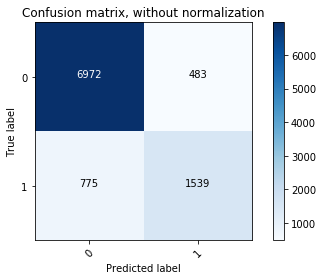

In [161]:
plot_confusion_matrix(cnf_matrix, classes=class_labels,
                      title='Confusion matrix, without normalization')

### Feature importance:

The global feature importance calcuations that come with XGBoost, enables us to view feature importances based on the following.

Feature Weights: This is based on the number of times a feature appears in a tree across the ensemble of trees
Gain: This is based on the average gain of splits which use the feature
Coverage: This is based on the average coverage (number of samples affected) of splits which use the feature

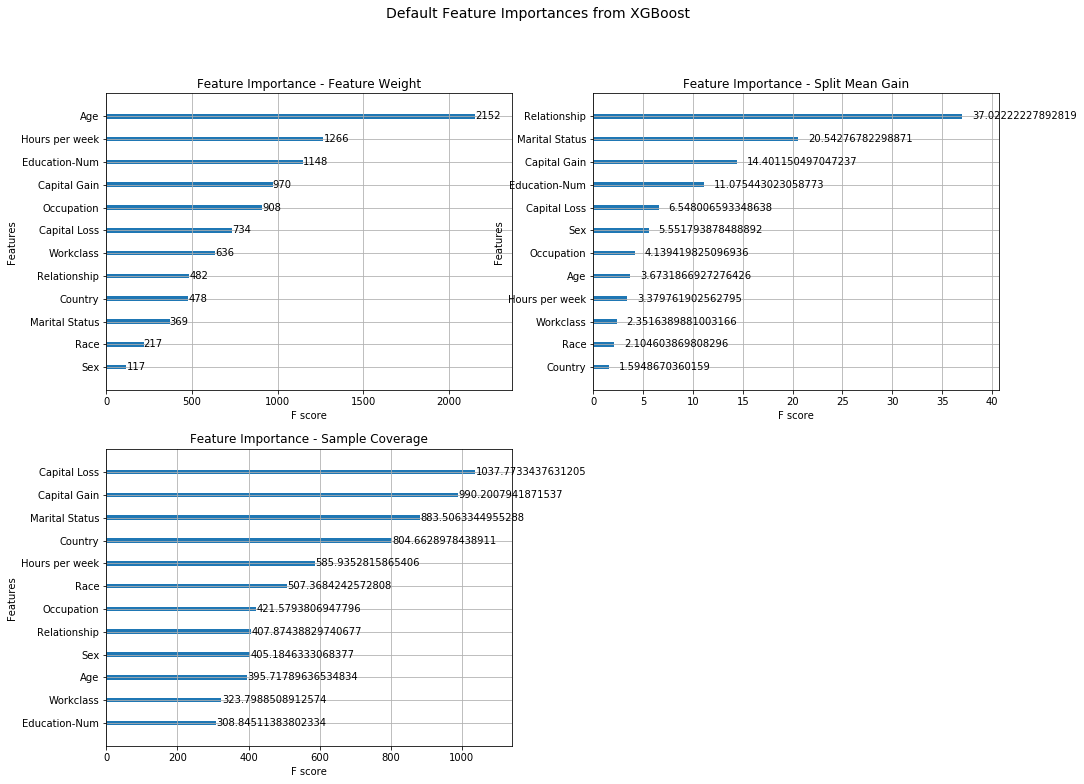

In [162]:
fig = plt.figure(figsize = (16, 12))
title = fig.suptitle("Default Feature Importances from XGBoost", fontsize=14)

ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

## Model Interpretation Methods


![](https://d3ansictanv2wj.cloudfront.net/Figure5-452aaf48771d7e201175954c1de6eed1.png)

## 1. LIME:

Lime is able to explain any black box classifier, with two or more classes. All we require is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. LIME tries to fit a global surrogate model, LIME focuses on fitting local surrogate models to explain why single predictions were made.

### Installation

SHAP can be installed from [PyPI](https://pypi.org/project/lime/)

```
pip install lime
```

or [conda-forge](https://anaconda.org/conda-forge/lime)

```
conda install -c conda-forge lime
```

Since XGBoost has some issues with feature name ordering when building models with dataframes, we will build our same model with numpy arrays to make LIME work. Remember the model being built is the same ensemble model which we treat as our black box machine learning model

In [163]:
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

__`LimeTabularExplainer`__ class helps in explaining predictions on tabular (i.e. matrix) data. For numerical features, it perturbs them by sampling from a Normal(0,1) and doing the inverse operation of mean-centering and scaling, according to the means and stds in the training data. For categorical features, it perturbs by sampling according to the training distribution, and making a binary feature that is 1 when the value is the same as the instance being explained. 


__`explain_instance()`__ function generates explanations for a prediction. First, we generate neighborhood data by randomly perturbing features from the instance. We then learn locally weighted linear (surrogate) models on this neighborhood data to explain each of the classes in an interpretable way.


In [113]:
explainer = LimeTabularExplainer(X_train.values, feature_names= headers, discretize_continuous=True, 
                                 class_names=['$50K or less', 'More than $50K'],verbose=True)

### When a person's income <= $50K

SHAP shows which features were the most influential in the model taking the correct decision of predicting the person's income as below $50K. The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [164]:
i = 0
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")

exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, distance_metric='euclidean')

Actual Label: 0
Predicted Label: 0
-----------------------------------
Intercept 0.7016083667998789
Prediction_local [-0.00034974]
Right: 0.0023078574


In [115]:
exp1 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba, distance_metric='euclidean')

Intercept 0.7840549784293785
Prediction_local [-0.00707363]
Right: 0.0023078574


In [165]:
exp1.show_in_notebook(show_table=True)

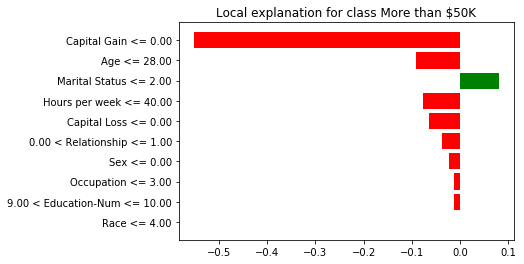

In [117]:
fig1 = exp1.as_pyplot_figure()

In [118]:
exp1.as_list()

[('Capital Gain <= 0.00', -0.5513588868260308),
 ('Age <= 28.00', -0.09187976341265806),
 ('Marital Status <= 2.00', 0.07990510887569083),
 ('Hours per week <= 40.00', -0.0773443715092592),
 ('Capital Loss <= 0.00', -0.06510866075939446),
 ('0.00 < Relationship <= 1.00', -0.03675193495996055),
 ('Sex <= 0.00', -0.02359477110804567),
 ('Occupation <= 3.00', -0.012959682194841822),
 ('9.00 < Education-Num <= 10.00', -0.012035649236100615),
 ('Race <= 4.00', 0.0)]

### When a person's income > $50K

In [119]:
i = 2
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")
exp2 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba,distance_metric='euclidean')

Actual Label: 1
Predicted Label: 1
-----------------------------------
Intercept 0.5488033802879485
Prediction_local [0.31691334]
Right: 0.69500035


In [120]:
exp2.show_in_notebook(show_table=True)

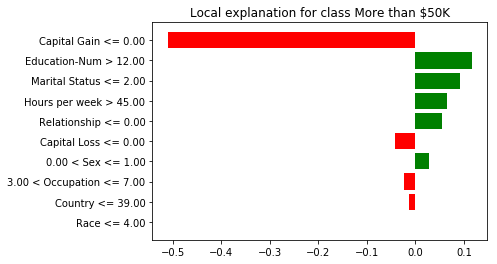

In [121]:
fig2 = exp2.as_pyplot_figure()

In [122]:
exp2.as_list()

[('Capital Gain <= 0.00', -0.5106754059439812),
 ('Education-Num > 12.00', 0.11649551628016877),
 ('Marital Status <= 2.00', 0.09141264498803986),
 ('Hours per week > 45.00', 0.06576088565305738),
 ('Relationship <= 0.00', 0.05446229527642146),
 ('Capital Loss <= 0.00', -0.041702404049509256),
 ('0.00 < Sex <= 1.00', 0.02886510068612558),
 ('3.00 < Occupation <= 7.00', -0.022566058879604844),
 ('Country <= 39.00', -0.013942615639121473),
 ('Race <= 4.00', 0.0)]

### When a person's income actual is different than predicted

In [123]:
i=12
X_test.iloc[i].values

array([41.,  4., 13.,  4., 10.,  1.,  4.,  1.,  0.,  0., 40., 39.],
      dtype=float32)

In [124]:
print('Actual Label:', y_test[i])
print('Predicted Label:', predictions[i])

print("-----------------------------------")
exp3 = explainer.explain_instance(X_test.iloc[i].values, xgc_np.predict_proba,distance_metric='euclidean')

Actual Label: 1
Predicted Label: 0
-----------------------------------
Intercept 0.6584810904059053
Prediction_local [0.14362618]
Right: 0.25080597


In [125]:
exp3.show_in_notebook(show_table=True)

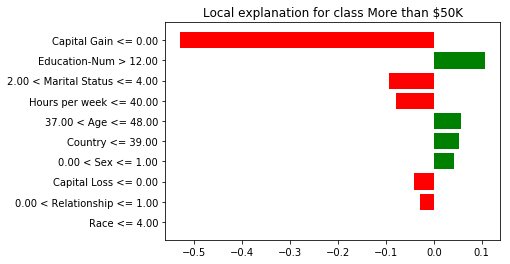

In [126]:
fig3 = exp3.as_pyplot_figure()

In [127]:
exp3.as_list ()

[('Capital Gain <= 0.00', -0.5286414500718264),
 ('Education-Num > 12.00', 0.10623848568234388),
 ('2.00 < Marital Status <= 4.00', -0.09390858037523336),
 ('Hours per week <= 40.00', -0.07935882803390214),
 ('37.00 < Age <= 48.00', 0.05713022709189785),
 ('Country <= 39.00', 0.05308184305849531),
 ('0.00 < Sex <= 1.00', 0.04123755555732045),
 ('Capital Loss <= 0.00', -0.04087477324137303),
 ('0.00 < Relationship <= 1.00', -0.029759389303548094),
 ('Race <= 4.00', 0.0)]

## 2. SHAP:

An intuitive way to understand the Shapley value is the following: The feature values enter a room in random order. All feature values in the room participate in the game (= contribute to the prediction). The Shapley value __$ϕ_{ij}$__ is the average marginal contribution of feature value __$x_{ij}$__ by joining whatever features already entered the room before, i.e.

$$\phi_{ij}=\sum_{\text{All.orderings}}val(\{\text{features.before.j}\}\cup{}x_{ij})-val(\{\text{features.before.j}\})$$

The following figure from the KDD 18 paper, [_Consistent Individualized Feature Attribution for Tree Ensembles_](https://arxiv.org/pdf/1802.03888.pdf) summarizes this in a nice way!

![](https://i.imgur.com/6Rc1dsa.png)

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

### Installation

SHAP can be installed from [PyPI](https://pypi.org/project/shap/)

```
pip install shap
```

or [conda-forge](https://anaconda.org/conda-forge/shap)

```
conda install -c conda-forge shap 
```

In [128]:
explainerS = shap.TreeExplainer(xgc)

In [129]:
shap_values = explainerS.shap_values(X_test)

In [130]:
print('Expected Value:', explainerS.expected_value)

Expected Value: -1.3625857


In [131]:
pd.DataFrame(shap_values).head()

0         1         2         3         4         5         6   \
0 -1.209206 -0.003895 -0.073927 -1.078541 -0.645259 -0.517731 -0.002871   
1  0.354368 -0.262398 -0.483883  0.586233  0.307967  1.194750  0.017408   
2 -0.525650  0.030637  0.970991  0.360480  0.528695  0.603971 -0.103895   
3 -0.426095  0.076188  0.576406 -1.108961 -0.517884 -0.522604  0.028896   
4 -0.503867 -0.159754 -0.129339 -0.547773 -0.049194 -0.414065 -0.019701   

         7         8         9         10        11  
0 -0.421329 -0.144742 -0.036394 -0.568053 -0.004587  
1 -0.216272 -0.108322 -0.048158 -0.095782  0.017657  
2  0.050630 -0.176231 -0.087669  0.509656  0.024573  
3 -0.359870 -0.142805 -0.057430 -0.250736  0.023183  
4  0.128197 -3.685364 -0.031033  0.781617  0.001285

This returns a matrix of SHAP values (`# samples x # features`). Each row sums to the difference between the model output for that sample and the expected value of the model output

### When a person's income <= $50K

The below explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the actual model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

In [132]:
shap.force_plot(explainerS.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

### When a person's income > $50K

In [133]:
shap.force_plot(explainerS.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

### When a person's income actual is different than predicted

In [134]:
shap.force_plot(explainerS.expected_value, shap_values[12,:], X_test_disp.iloc[12,:])

### Visualizing multiple predictions:
Model prediction decisions for the first 3000 test data samples.

In [137]:
shap.force_plot(explainerS.expected_value, shap_values[:3000,:], X_test_disp.iloc[:3000,:])

__Interesting points__:
- The first 100 test samples all probably __earn more than \$50K__ and they __are married__ or\and have a __good capital gain__ or\and have a __higher education level__!
- The next 170+ test samples all probably __earn less than or equal to \$50K__ and they __are mostly un-married__ and\or are __very young in age or divorced__!
- The next 310+ test samples have an inclination towards mostly __earning more than \$50K__ and they are of diverse profiles including married folks, people with different age and education levels and occupation. Most dominant features pushing the model towards making a prediction for higher income is the person being married i.e. __relationship: husband or wife__!
- The remaining 400+ test samples have an inclination towards mostly __earning less than \$50K__ and they are of diverse profiles however dominant patterns include __relationship: either unmarried or divorced__ and __very young in age__! 

### Feature importance bar chart:
This basically takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.

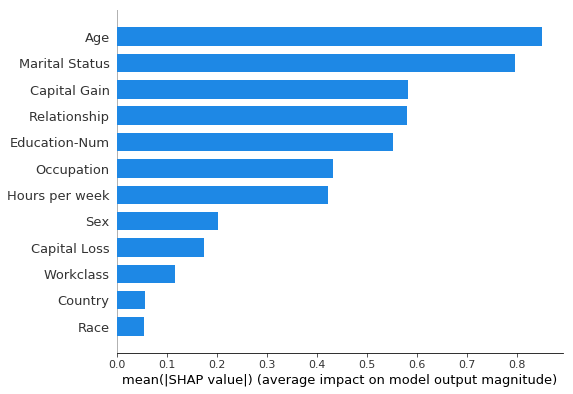

In [138]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

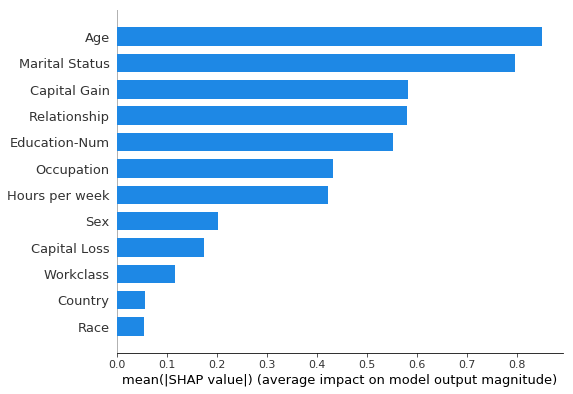

In [139]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

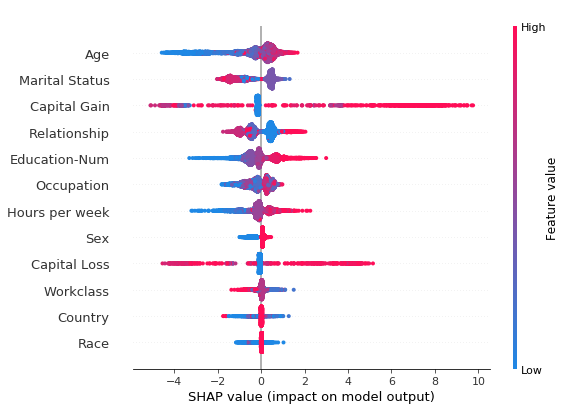

In [141]:
shap.summary_plot(shap_values, X_test)

### SHAP Dependence Plots:

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

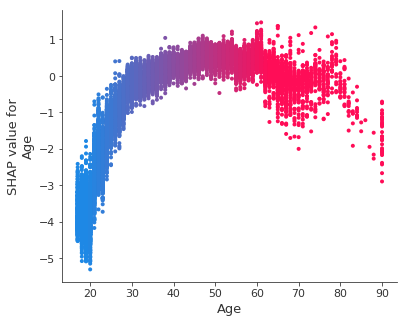

In [59]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_train,  
                     display_features=X_train_disp)

The middle-aged people have a slightly higher shap value, pushing the model's prediction decisions to say that these individuals make more money as compared to younger or older people

### Two-way Dependence Plots:

Two-way PDP showing interactions between features 'Age' and 'Capital Gain' and their effect on making more than $50K
The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. Here we are trying to see interactions between Age and Capital Gainand also their effect on the SHAP values which lead to the model predicting if the person will make more money or not, with the help of a two-way partial dependence plot.

Interesting to see higher the higher capital gain and the middle-aged people (30-50) having the highest chance of making more money!

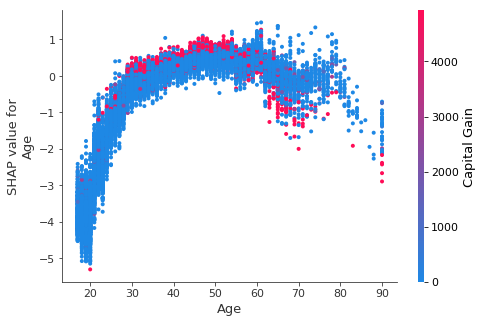

In [161]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_train, 
                     display_features=X_train_disp)

### References:

- LIME: https://github.com/marcotcr/lime

- SHAP: https://github.com/slundberg/shap

- Hands-on Machine Learning Model Interpretation: https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608
